# Table of Contents
1. [Libraries](#libraries)
2. [Settings](#settings)
3. [Data](#data)
4. [Selected Models Results](#selected-model-results)
   1. [Table of Selected Model Results](#table-of-selected-model-results)
   2. [Expert vs. Non-Expert](#expert-vs-non-expert)
   3. [Human vs. Machine Generated Datasets](#human-vs-machine-generated-datasets)
5. [Valid Response Rates](#valid-response-rates)
   1. [Valid Response Rates Per Model](#valid-response-rates-per-model)
   2. [Valid Response Rates Per Dataset](#valid-response-rates-per-dataset)
6. [Properties Analysis](#properties-analysis)
7. [All Model Results (Table 3)](#all-model-results)

# 1. Libraries <a id="libraries"></a>

In [1]:
import json
import pandas as pd
import time

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, spearmanr
import colorcet as cc

from results.utils.get_results_dataframes import json_to_df, plot_experts_vs_non_experts, plot_human_vs_machine

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.set_option("display.precision", 2)
palette = sns.color_palette(cc.glasbey_hv, n_colors=25)
sns.set_theme(style="whitegrid", palette=palette) 

## 2. Settings <a class="anchor" id="settings"></a>
1- Path to files with evaluation results (e.g., `./results/<%d-%m-%Y>`),

2- Get the `candidate models` `dataset names`, `model names`, and `name mappings (e.g., short names for models and task types` 
You can here change the list of models to be reported in the main paper in `results.name_mappings`

In [4]:
date = time.strftime("%d-%m-%Y")
results_path = f"./results/regular"  # WARN: change to CoT for CoT results

# WARN: assumes [cola] dataset has responses from all models
model_names = list(reversed(list(json.load(open(f"{results_path}/cola.json")).keys())))
model_names += list(
    reversed(list(json.load(open(f"{results_path}/wmt-23-zh-en.json")).keys()))
)
model_names += list(
    reversed(list(json.load(open(f"{results_path}/wmt-23-en-de.json")).keys()))
)
model_names = set(model_names)

from results.utils.name_mappings import dataset_names, candidate_models, all_models, models_short_names, task_cabapility_mappings, tasks_dataset_names, dataset_human_vs_machines, subtask_to_cat

# 3. Data <a class="anchor" id="data"></a>
## `.json` to DataFrame and DataFrame to `.xlsx`:

In [5]:
xlsx_fpath = f'{results_path}/eval_results.xlsx'
all_results = []
with pd.ExcelWriter(xlsx_fpath) as writer:
    for dataset in dataset_names:
        # print(f'{dataset.upper()}: json to dataframe', end=' ')
        df, dataset_results = json_to_df(f'{results_path}/{dataset}.json')
        df.to_excel(writer, sheet_name=dataset)
        all_results.extend(dataset_results)
df_all_results = pd.DataFrame(all_results)
print(f'\nall datasets converted – use a spreadsheet app to open {xlsx_fpath}!')
# remove gpt3 
df_all_results = df_all_results[~df_all_results['model'].str.contains('gpt-3.5')]


all datasets converted – use a spreadsheet app to open ./results/regular/eval_results.xlsx!


# 4. Selected Models Results <a class="anchor" id="selected-model-results"></a>
Select results of the `candidate models` based on the highest valid reponse rate and performance


In [6]:
df_all_results['expert'] = df_all_results['expert'].replace({'true': 'Experts', 'false': 'Crowdsource', 'unknown': 'Mixed', 'uknown': 'Mixed'})
df_all_results.rename(columns={'expert': 'Annotators'}, inplace=True)
selected_df_all_results = df_all_results[df_all_results['model'].isin(candidate_models)]

## 4.1 Table of Selected Model Results <a class="anchor" id = "table-of-selected-model-results"></a>
`Table 1` in the main paper: Scores per dataset for the models with >97 valid response rates
Cohen's kappa for categorical annotations and Spearman's correlation for graded annotations. Datasets with both categorical and graded annotations appear twice. Datasets in \colorbox{blue!25}{blue} concern human-generated language, while those in \colorbox{red!25}{red} concern model-generated text.  `$\sigma$' denotes the standard deviation of the scores across models per dataset (averaged over properties if more than one is judged per dataset

In [7]:
from results.utils.generate_tables import get_model_per_dataset_score
categorical_models_per_dataset_score = get_model_per_dataset_score(
    selected_df_all_results, type="categorical"
)
graded_models_per_dataset_score = get_model_per_dataset_score(
    selected_df_all_results, type="graded"
)
# combine the two dataframes
models_per_dataset_score = pd.concat(
    [categorical_models_per_dataset_score, graded_models_per_dataset_score], axis=0
)
models_per_dataset_score = models_per_dataset_score.rename(
    columns={"Dataset (#Subtasks)": "Dataset (\#Subtasks)"}
)
models_per_dataset_score.to_latex(
    f"results/models_per_dataset_score.tex", index=False, column_format="llllllll|cc"
)
models_per_dataset_score

,Type,Dataset (\#Subtasks),GPT-4o,Llama-3.1-70B,Mixtral-8x22B,Gemini-1.5,Mixtral-8x7B,Comm-R+,$\sigma$,$\alpha$
0,,\cellcolor{blue!25}cola (1),0.34,0.46,0.54,0.45,0.55,0.12,0.15,-
1,,\cellcolor{blue!25}llmbar-natural (1),0.84,0.8,0.72,0.79,0.54,0.56,0.13,-
2,,\cellcolor{blue!25}llmbar-adversarial (1),0.58,0.46,0.2,0.29,0.06,0.11,0.25,-
3,,\cellcolor{blue!25}toxic-chat (2),0.49 ± 0.36,0.41 ± 0.26,0.45 ± 0.27,0.45 ± 0.35,0.36 ± 0.12,0.28 ± 0.35,0.09,-
4,,\cellcolor{blue!25}cola-grammar (63),0.47 ± 0.22,0.28 ± 0.24,0.28 ± 0.23,0.26 ± 0.24,0.21 ± 0.18,0.13 ± 0.14,0.14,-
5,,\cellcolor{red!25}topical-chat (2),0.05 ± 0.07,-0.02 ± 0.02,-0.03 ± 0.04,-0.03 ± 0.04,0.02 ± 0.03,0.01 ± 0.02,0.14,0.08
6,,\cellcolor{red!25}roscoe-gsm8k (2),0.59 ± 0.35,0.64 ± 0.27,0.62 ± 0.38,0.6 ± 0.24,0.58 ± 0.36,0.0 ± 0.0,0.15,-
7,,\cellcolor{red!25}roscoe-esnli (2),0.29 ± 0.06,0.38 ± 0.08,0.13 ± 0.13,0.11 ± 0.18,0.1 ± 0.11,0.03 ± 0.05,0.14,-
8,,\cellcolor{red!25}dices-990 (1),-0.24,-0.17,-0.16,-0.12,-0.2,-0.09,0.05,0.14
9,,\cellcolor{red!25}inferential-strategies (1),0.42,0.4,0.02,0.22,0.06,-0.02,0.18,1.0


## 4.2 Expert vs. Non-Expert <a class="anchor" id="expert-vs-non-expert"></a>

Plotting the scores of the models across annotation types (i.e., expert vs crowd)

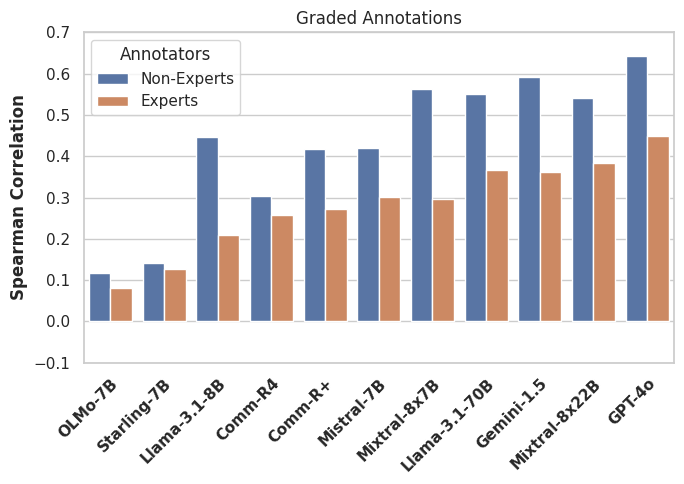

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
fig, axs = plt.subplots(1, figsize=(7, 5))
ax_grad, grad_filtered_data = plot_experts_vs_non_experts(df_all_results[df_all_results['model']!= 'OLMo-7B-Instruct'], 'graded', ax=axs)
plt.tight_layout()
plt.show()

## 4.3 Human vs. Machine Generated Datasets <a class="anchor" id="human-vs-machine-generated-datasets"></a>
`Figure 6`: Scores (Cohen's $\kappa$ for categorical annotations and Spearman's correlation for graded annotations) on test items involving  human language vs.~machine-generated outputs.

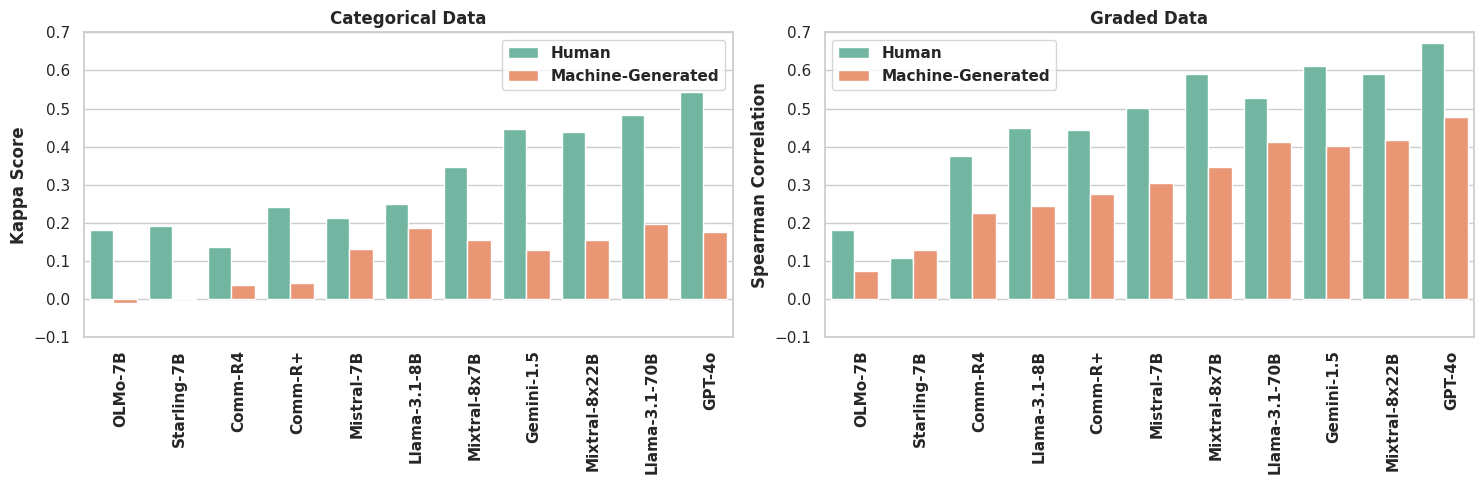

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax_cat, cat_filtered_data = plot_human_vs_machine(df_all_results, 'categorical', ax=axs[0])
ax_grad, grad_filtered_data = plot_human_vs_machine(df_all_results, 'graded', ax=axs[1])
plt.tight_layout()
# Save the plot transparently
plt.savefig(f'./results/human_vs_machine_generated.pdf', bbox_inches='tight', pad_inches=0.1, dpi=300, transparent=True)
plt.show()

# 5. Valid Response Rates <a class="anchor" id="valid-response-rates"></a>
## 5.1 Valid Response Rates Per Model <a class="anchor" id = "valid-response-rates-per-model"></a>
`Figure 4`: Plotting the response ratio per model

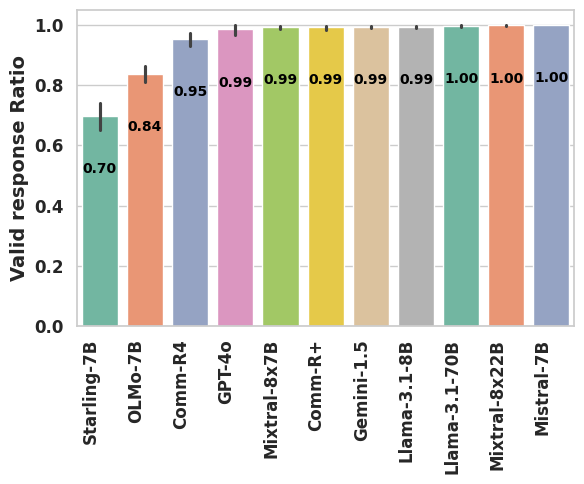

In [10]:
model_response_scores = df_all_results.groupby('model')['response_ratio'].mean().sort_values(ascending=True)
df_all_results['model'] = pd.Categorical(df_all_results['model'], categories=model_response_scores.index, ordered=True)
response_ratio = df_all_results.groupby(['model'])['response_ratio'].mean().reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(6, 5))
ax = sns.barplot(x='model', y='response_ratio', data=df_all_results, order=model_response_scores.index, palette='Set2')
plt.xticks(rotation=90, ha='right')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height() - 0.2), 
                ha='center', va='center', fontsize=10, color='black', 
                xytext=(0, 5), textcoords='offset points', fontweight='bold')
plt.ylabel('Valid response Ratio', fontsize=14, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax.set_xticklabels([models_short_names[model.get_text()] for model in ax.get_xticklabels()])
plt.tight_layout()
# save tranparent pdf
plt.savefig(f'./results/models_valid_response_ratio.pdf', transparent=True, bbox_inches='tight')
plt.show()

## 5.2 Valid Response Rates Per Dataset <a class="anchor" id = "valid-response-rates-per-dataset"></a>
`Figure 5`: Plotting the `valid response ratio` per dataset

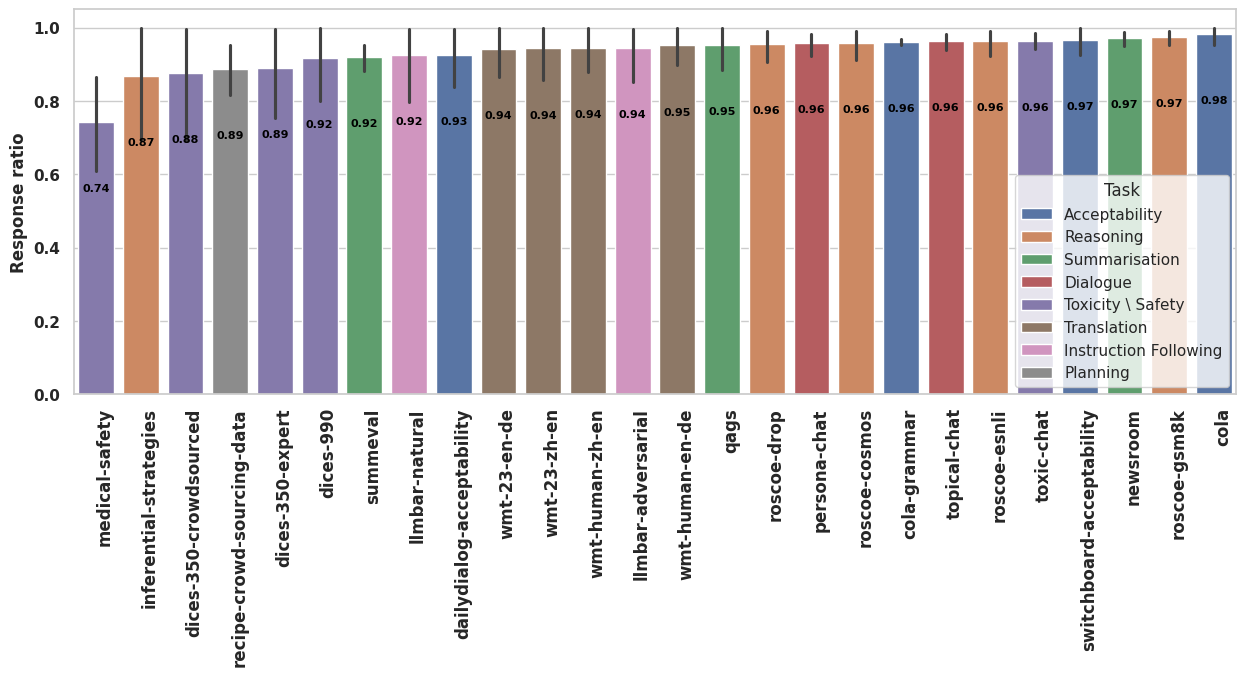

In [11]:

dataset_scores = df_all_results.groupby('dataset')['response_ratio'].mean().sort_values(ascending=True)
df_all_results['dataset'] = pd.Categorical(df_all_results['dataset'], categories=dataset_scores.index, ordered=True)
response_ratio = df_all_results.groupby(['dataset', 'model'])['response_ratio'].mean().reset_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='dataset', y='response_ratio', data=df_all_results, hue='task')
plt.xticks(rotation=90)
# put the response ratio on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()-0.2), ha='center', va='center', fontsize=8, color='black', xytext=(0, 5), textcoords='offset points', fontweight='bold')
plt.ylabel('Response ratio', fontsize=12, fontweight='bold')
plt.xlabel('')
plt.xticks(fontsize=12, ha='right', rotation_mode="anchor", fontweight='bold')
plt.legend(title='Task')
plt.yticks(fontweight='bold')
plt.savefig(f'./results/dataset_valid_response_ratio.pdf', transparent=True, bbox_inches='tight')
plt.show()

# 6. Properties Analysis <a class="anchor" id="properties-analysis"></a>
Correlation scores for those properties with exclusively graded judgements across datasets: `Figure 3`

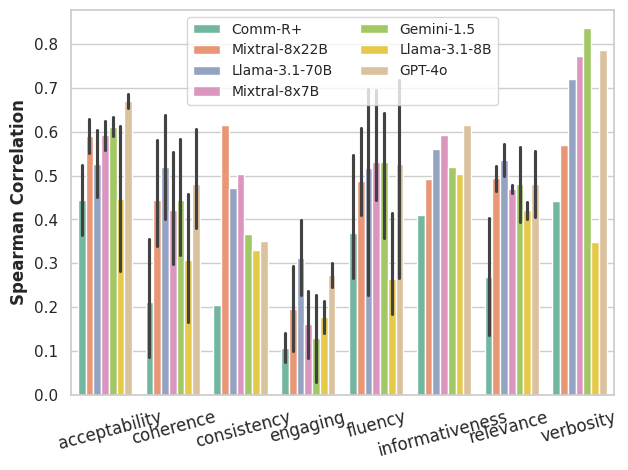

In [12]:
from results.utils.get_results_dataframes import get_model_per_category_score
selected_df_all_results["category"] = selected_df_all_results["subtask"].str.lower().map(
    subtask_to_cat
)
selected_df_cat_results = selected_df_all_results[selected_df_all_results["category"] != "remove"]
selected_df_cat_results = selected_df_cat_results[selected_df_cat_results["category"] != "grammaticality"]

graded_models_per_category_score = get_model_per_category_score(
    selected_df_cat_results,
)
graded_models_per_category_score.to_latex(
    f"results/models_per_category_score.tex", index=False, column_format="llllllll|cc"
)
selected_df_cat_results = selected_df_cat_results[
            selected_df_cat_results["type"] != "categorical"
        ]
selected_df_cat_results = selected_df_cat_results.sort_values(by="value")
selected_df_cat_results = selected_df_cat_results.sort_values(by="category")
selected_df_cat_results["model"] = selected_df_cat_results["model"].map(models_short_names)

plt.figure(figsize=(7, 5))
sns.barplot(
    hue="model",
    y="value",
    data=selected_df_cat_results,
    x="category",
    palette='Set2'
)
plt.xticks(
    [0.8, 1.6, 2.7, 3.5, 4.4, 5.9, 6.5, 7.5],
    labels=[
        "acceptability",
        "coherence",
        "consistency",
        "engaging",
        "fluency",
        "informativeness",
        "relevance",
        "verbosity",
    ],
    rotation=15,
    fontsize=12,
    ha="right",
    rotation_mode="anchor",
)
plt.legend(loc="best", fontsize=10, ncol=2)
plt.ylabel("Spearman Correlation", fontsize=12, fontweight="bold")
plt.xlabel("")
plt.savefig(
    f"./results/across_task_categories.pdf", transparent=True, bbox_inches="tight"
)

# 7. All Model Results (Table 3) <a class="anchor" id="all-model-results"></a>
`Table 3`: All Models performance per dataset.

In [13]:
from results.utils.generate_tables import get_all_models_per_dataset_score
df_all_results = pd.DataFrame(all_results)
print(f'\nall datasets converted – use a spreadsheet app to open {xlsx_fpath}!')
# remove gpt3 
df_all_results = df_all_results[~df_all_results['model'].str.contains('gpt-3.5')]
categorical_models_per_dataset_score = get_all_models_per_dataset_score(
    df_all_results, type="categorical"
)
graded_models_per_dataset_score = get_all_models_per_dataset_score(
    df_all_results, type="graded"
)
# combine the two dataframes
models_per_dataset_score = pd.concat(
    [categorical_models_per_dataset_score, graded_models_per_dataset_score], axis=0
)
models_per_dataset_score = models_per_dataset_score.rename(
    columns={"Dataset (#Subtasks)": "Dataset (\#Subtasks)"}
)
models_per_dataset_score.to_latex(
    f"results/all_models_per_dataset_score.tex",
    index=False,
    column_format="lllllllllllll",
)
models_per_dataset_score


all datasets converted – use a spreadsheet app to open ./results/regular/eval_results.xlsx!


,Type,Dataset (\#Subtasks),GPT-4o,Llama-3.1-70B,Mixtral-8x22B,Gemini-1.5,Mixtral-8x7B,Comm-R+,Comm-R4,Llama-3.1-8B,Mistral-7B,Starling-7B,OLMo-7B
0,,\cellcolor{blue!25}cola (1),0.34,0.46,0.54,0.45,0.55,0.12,0.01,0.42,0.43,0.45,0.42
1,,\cellcolor{blue!25}llmbar-natural (1),0.84,0.8,0.72,0.79,0.54,0.56,0.59,0.57,0.3,0.28,0.24
2,,\cellcolor{blue!25}llmbar-adversarial (1),0.58,0.46,0.2,0.29,0.06,0.11,-0.2,-0.18,-0.2,-0.12,-0.1
3,,\cellcolor{blue!25}toxic-chat (2),0.49 ± 0.36,0.41 ± 0.26,0.45 ± 0.27,0.45 ± 0.35,0.36 ± 0.12,0.28 ± 0.35,0.2 ± 0.21,0.34 ± 0.29,0.45 ± 0.18,0.27 ± 0.26,0.3 ± 0.13
4,,\cellcolor{blue!25}cola-grammar (63),0.47 ± 0.22,0.28 ± 0.24,0.28 ± 0.23,0.26 ± 0.24,0.21 ± 0.18,0.13 ± 0.14,0.08 ± 0.1,0.1 ± 0.14,0.09 ± 0.13,0.07 ± 0.08,0.04 ± 0.06
5,,\cellcolor{red!25}topical-chat (2),0.05 ± 0.07,-0.02 ± 0.02,-0.03 ± 0.04,-0.03 ± 0.04,0.02 ± 0.03,0.01 ± 0.02,0.01 ± 0.01,0.57 ± 0.61,-0.03 ± 0.05,0.04 ± 0.06,0.03 ± 0.04
6,,\cellcolor{red!25}roscoe-gsm8k (2),0.59 ± 0.35,0.64 ± 0.27,0.62 ± 0.38,0.6 ± 0.24,0.58 ± 0.36,0.0 ± 0.0,0.21 ± 0.03,0.36 ± 0.31,0.47 ± 0.34,-0.03 ± 0.01,-0.01 ± 0.02
7,,\cellcolor{red!25}roscoe-esnli (2),0.29 ± 0.06,0.38 ± 0.08,0.13 ± 0.13,0.11 ± 0.18,0.1 ± 0.11,0.03 ± 0.05,-0.01 ± 0.01,0.14 ± 0.2,0.02 ± 0.09,0.01 ± 0.07,-0.04 ± 0.09
8,,\cellcolor{red!25}dices-990 (1),-0.24,-0.17,-0.16,-0.12,-0.2,-0.09,-0.02,-0.11,-0.12,-0.05,0.0
9,,\cellcolor{red!25}inferential-strategies (1),0.42,0.4,0.02,0.22,0.06,-0.02,-0.12,0.13,0.01,0.01,0.04
